# SPT Empirical–Mock Background Comparison
Author: Benjamin Floyd

Visualizes the local background distributions in both the true empirical and mock datasets.

In [1]:
import json
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import QTable, join, vstack, Table
from astropy.wcs import WCS
from scipy.interpolate import interp1d

In [2]:
def calculate_area(mask_files: list) -> u.Quantity:
    # Read in each mask file and calculate the allowable area
    areas = []
    for mask_file in mask_files:
        mask_img, mask_hdr = fits.getdata(mask_file, header=True)
        mask_wcs = WCS(mask_hdr)

        # Get the area of a pixel in angular units
        pixel_area = mask_wcs.proj_plane_pixel_area()

        # Find the total area of the image by adding all pixels and multiplying by the pixel area
        mask_area = np.count_nonzero(mask_img) * pixel_area
        areas.append(mask_area)

    # Compute total area in sample
    return u.Quantity(areas).sum()

## Empirical Data

In [3]:
# Read in the color threshold--redshift relation
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color_4.5_17.48.json', 'r') as f:
    sdwfs_purity_data = json.load(f)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
color_bins = sdwfs_purity_data['purity_90_colors']
agn_purity_color = interp1d(z_bins, color_bins, kind='previous')

In [4]:
# Read in the AGN catalog
sptcl_iragn = QTable.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTcl_IRAGN_no-stars.fits')

# Also read in the local background surface density file
with open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_frac_err_pivot.json') as f:
    local_bkgs = json.load(f)
# Recast as a table
local_bkgs = QTable(rows=[[cluster_name, surf_den] for cluster_name, surf_den in local_bkgs.items()], names=['SPT_ID', 'local_bkg_surf_den'], units=[None, u.deg**-2])

In [5]:
# Ensure only AGN are in the catalog
sptcl_iragn = sptcl_iragn[sptcl_iragn['SELECTION_MEMBERSHIP'] >= 0.5]

# Group the catalog by cluster
sptcl_iragn_grp = sptcl_iragn.group_by('SPT_ID')

# Gather cluster information
cluster_info = vstack([QTable(cluster['SPT_ID', 'SZ_RA', 'SZ_DEC', 'REDSHIFT', 'M500', 'R500'][0]) for cluster in sptcl_iragn_grp.groups])

In [6]:
# Compute the line-of-sight surface densities
los_surf_dens = []
for cluster in sptcl_iragn_grp.groups:
    cluster_id = cluster['SPT_ID'][0]
    mask_name = cluster['MASK_NAME'][0]

    # Compute the number of AGN in the line-of-sight
    los_no_agn = cluster['COMPLETENESS_CORRECTION'].sum()

    # Compute the area of the line-of-sight field
    los_area = calculate_area([mask_name])

    los_surf_den = los_no_agn / los_area
    los_surf_dens.append([cluster_id, los_no_agn, los_area, los_surf_den])
los_surf_dens = QTable(rows=los_surf_dens, names=['SPT_ID', 'los_no_agn', 'los_area', 'los_surf_den'], units=[None, None, u.deg**2, u.deg**-2])

In [7]:
# Merge the two tables
sptcl_surf_dens = join(los_surf_dens, local_bkgs, keys='SPT_ID')

# Add the cluster information
sptcl_surf_dens = join(sptcl_surf_dens, cluster_info, keys='SPT_ID')

In [8]:
# Compute the expected number of background AGN in the line of sight
sptcl_surf_dens['los_no_agn_bkg'] = (sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area']).value

# Also, convert units and strip
sptcl_surf_dens['local_bkg_surf_den'] = sptcl_surf_dens['local_bkg_surf_den'].to_value(u.arcmin**-2)
sptcl_surf_dens['los_area'] = sptcl_surf_dens['los_area'].to_value(u.arcmin**2)

In [9]:
# Bin the data by the color bins
sptcl_surf_dens['selection_color'] = agn_purity_color(sptcl_surf_dens['REDSHIFT'])
sptcl_surf_dens_color_grp = sptcl_surf_dens.group_by('selection_color')

# Also bin the data by redshift bins
sptcl_surf_dens_z_grp = sptcl_surf_dens.group_by(np.digitize(sptcl_surf_dens['REDSHIFT'], z_bins))

In [10]:
# Compute the means and standard deviations within the bins
bkg_agn_means_color = sptcl_surf_dens_color_grp['los_no_agn_bkg'].groups.aggregate(np.mean)
bkg_agn_stds_color = sptcl_surf_dens_color_grp['los_no_agn_bkg'].groups.aggregate(np.std)

bkg_agn_means_z = sptcl_surf_dens_z_grp['los_no_agn_bkg'].groups.aggregate(np.mean)
bkg_agn_stds_z = sptcl_surf_dens_z_grp['los_no_agn_bkg'].groups.aggregate(np.std)

In [11]:
z_bin_centers = np.array(z_bins)[:-1] + np.diff(z_bins) / 2

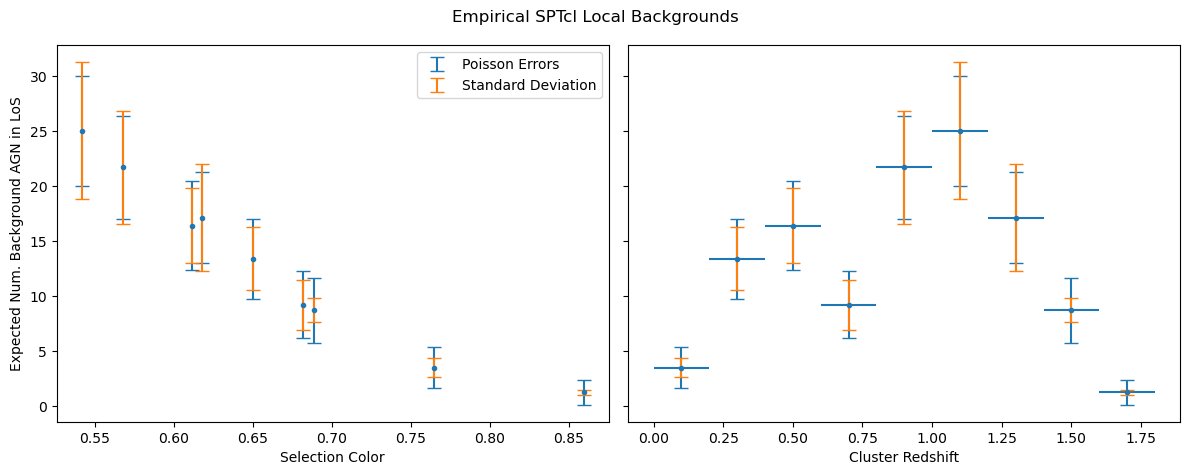

In [12]:
fig, (ax, bx) = plt.subplots(ncols=2, sharey='row', figsize=(6.0 * 2, 4.8), tight_layout=True)
ax.errorbar(sptcl_surf_dens_color_grp.groups.keys['selection_color'], bkg_agn_means_color, fmt='.')
ax.errorbar(sptcl_surf_dens_color_grp.groups.keys['selection_color'], bkg_agn_means_color, yerr=np.sqrt(bkg_agn_means_color), fmt='none', capsize=5., label='Poisson Errors')
ax.errorbar(sptcl_surf_dens_color_grp.groups.keys['selection_color'], bkg_agn_means_color, yerr=bkg_agn_stds_color, fmt='none', ecolor='tab:orange', capsize=5., label='Standard Deviation')
ax.legend()
ax.set(xlabel='Selection Color', ylabel=r'Expected Num. Background AGN in LoS')

bx.errorbar(z_bin_centers, bkg_agn_means_z, xerr=np.diff(z_bins) / 2, fmt='.')
bx.errorbar(z_bin_centers, bkg_agn_means_z, yerr=np.sqrt(bkg_agn_means_z), fmt='none', capsize=5.)
bx.errorbar(z_bin_centers, bkg_agn_means_z, yerr=bkg_agn_stds_z, fmt='none', ecolor='tab:orange', capsize=5.)
bx.set(xlabel='Cluster Redshift')
fig.suptitle('Empirical SPTcl Local Backgrounds')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/plots/empirical-mock/empirical_local_bkg_color-z_errors.pdf')

# Mock 

In [13]:
# Read in the mock catalog
mock_cat = QTable.read('Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Catalogs/local_backgrounds/background_test/mock_AGN_catalog_t0.0000_e0.00_z0.00_b1.00_rc0.100_C-local_maxr5.00_seed3775_308x1.0_local_bkg_test.fits')

# Isolate the background objects
mock_cat_bkg = mock_cat[~mock_cat['CLUSTER_AGN'].astype(bool)]

In [14]:
# Count the number of objects in the mock los's
mock_no_agn = []
for cluster in mock_cat_bkg.group_by('SPT_ID').groups:
    # cluster['no_bkg_agn'] = cluster['COMPLETENESS_CORRECTION'].sum()
    cluster['no_bkg_agn'] = len(cluster)
    mock_no_agn.append(cluster)
mock_cat_bkg = vstack(mock_no_agn)

In [15]:
# We only care about numbers at the cluster/LoS level
mock_cat_bkg_los = Table(rows=[cluster[0] for cluster in mock_cat_bkg.group_by('SPT_ID').groups], names=mock_cat_bkg.colnames)

In [16]:
# Bin the Mock data by the color bins
mock_cat_bkg_los['selection_color'] = agn_purity_color(mock_cat_bkg_los['REDSHIFT'])
mock_cat_bkg_color_grp = mock_cat_bkg_los.group_by('selection_color')

# Also bin by redshift bins
mock_cat_bkg_z_grp = mock_cat_bkg_los.group_by(np.digitize(mock_cat_bkg_los['REDSHIFT'], z_bins))

In [17]:
# Compute the mock means and standard deviations
mock_cat_bkg_color_mean = mock_cat_bkg_color_grp['c_true'].groups.aggregate(np.mean)
mock_cat_bkg_color_std = mock_cat_bkg_color_grp['c_true'].groups.aggregate(np.std)

mock_cat_bkg_z_mean = mock_cat_bkg_z_grp['c_true'].groups.aggregate(np.mean)
mock_cat_bkg_z_std = mock_cat_bkg_z_grp['c_true'].groups.aggregate(np.std)

In [18]:
# Compute the trends with respect to the surface densities in the empirical background
empirical_bkg_color_mean = sptcl_surf_dens_color_grp['local_bkg_surf_den'].groups.aggregate(np.mean)
empirical_bkg_color_std = sptcl_surf_dens_color_grp['local_bkg_surf_den'].groups.aggregate(np.std)

empirical_bkg_z_mean = sptcl_surf_dens_z_grp['local_bkg_surf_den'].groups.aggregate(np.mean)
empirical_bkg_z_std = sptcl_surf_dens_z_grp['local_bkg_surf_den'].groups.aggregate(np.std)

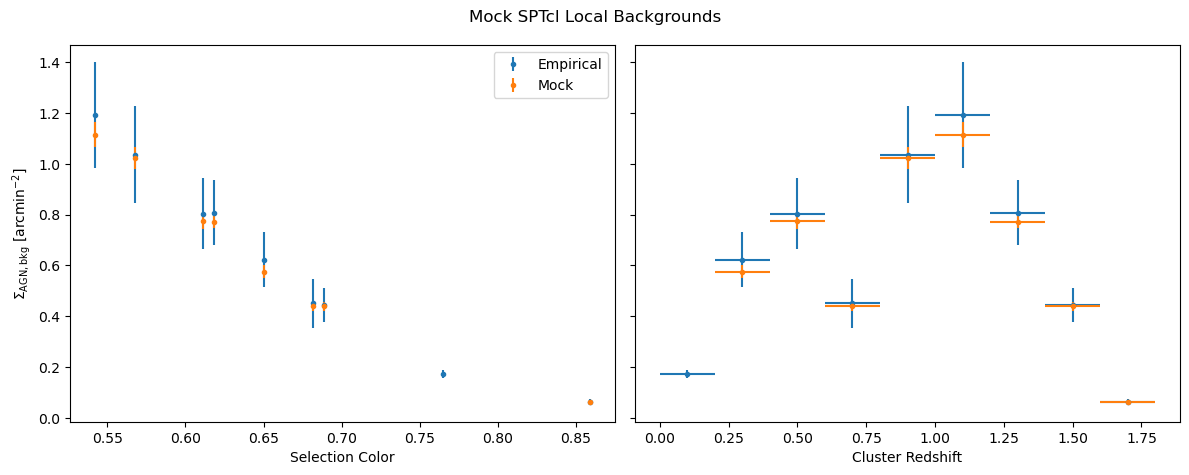

In [19]:
fig, (ax, bx) = plt.subplots(ncols=2, sharey='row', figsize=(6.0 * 2, 4.8), tight_layout=True)
ax.errorbar(sptcl_surf_dens_color_grp.groups.keys['selection_color'], empirical_bkg_color_mean, yerr=empirical_bkg_color_std, fmt='.', label='Empirical')
ax.errorbar(mock_cat_bkg_color_grp.groups.keys['selection_color'], mock_cat_bkg_color_mean, yerr=mock_cat_bkg_color_std, fmt='.', label='Mock')
ax.legend()
ax.set(xlabel='Selection Color', ylabel=r'$\Sigma_{\rm AGN, bkg}$ [arcmin$^{-2}$]')

bx.errorbar(z_bin_centers, empirical_bkg_z_mean, xerr=np.diff(z_bins) / 2, yerr=empirical_bkg_z_std, fmt='.', label='Empirical')
bx.errorbar(z_bin_centers[1:], mock_cat_bkg_z_mean, xerr=np.diff(z_bins)[1:] / 2, yerr=mock_cat_bkg_z_std, fmt='.', label='Mock')
bx.set(xlabel='Cluster Redshift')
fig.suptitle('Mock SPTcl Local Backgrounds')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/plots/empirical-mock/mock-empirical_surf_dens_color-z.pdf')